# DESAFIOS
Resolucion del desafio propuesto para spot2 detallado en https://github.com/sightes/DESAFIOS/blob/main/Data%20Challenge%202.0.pdf

Para visualizar y ejecutar el desafio https://colab.research.google.com/github/sightes/DESAFIOS/blob/main/Spot2.ipynb


# IMPORTANTE !

Las 2 primeras celdas, descargan directamente los datos desde https://www.inegi.org.mx/app/descarga/?ti=6 y consideran los topicos :

      - Comercio por menor 
      - Servicios de alojamiento temporal y de preparación de alimentos y bebidas
      
      
# Entorno de desarrollo

Se selecciono Google Colab , debido a que utiliza el proceso en la nube, requerimientos de desempeno, sin embargo , esto 
puede extenderse a alguna infrestructura mas sofisticada siempre cuando lo amerite

# Modo de ejecucion 

Ejecutar las celdas respectivas paso a paso 

# Como Funciona?

  - El algoritmo descarga los comercios registrados en formato CSV , luego se descomprimen y secuencialmente se exploca carpeta por carpeta, extrayendo y limpiando la data
   
  - Se trabaja sobre los nombres del comercio, buscando las palabras "pizza" o "pizzer"
  
  - luego se recorre la tabla solicitada por el cliente, la cual se contrasta con las pizzerias registradas los ultimos 3 anios, con esto se proyecta en un mapa ,
  para luego calcular las distancias en kilometros respecto a cada objetivo ( se valido contra google maps el funcionamiento de esta metrica)
  
  - Finalmente se genera un grafico de barras a fin de saber la distribucion en terminos de trabajadores de la competencia .

# Problemas conocidos 

a veces se confunde con la palabra pizzarro , pizzarrenio etc etc , en futuras versiones podria ser arreglado dicho bug

# to do 

-Generacion de reporte 
-Mejoras de rendimiento
-Arreglo de bugs 
-Optimizacion y seleccion de lugares en cercanias 

  


In [22]:
#%%capture
#descarga archivos
!wget 'https://www.inegi.org.mx/contenidos/masiva/denue/denue_00_46111_csv.zip'
!wget 'https://www.inegi.org.mx/contenidos/masiva/denue/denue_00_46112-46311_csv.zip'
!wget 'https://www.inegi.org.mx/contenidos/masiva/denue/denue_00_46321-46531_csv.zip'
!wget 'https://www.inegi.org.mx/contenidos/masiva/denue/denue_00_46591-46911_csv.zip'
!wget 'https://www.inegi.org.mx/contenidos/masiva/denue/denue_00_72_1_csv.zip'
!wget 'https://www.inegi.org.mx/contenidos/masiva/denue/denue_00_72_2_csv.zip'


--2022-06-13 12:48:21--  https://www.inegi.org.mx/contenidos/masiva/denue/denue_00_46111_csv.zip
Resolving www.inegi.org.mx (www.inegi.org.mx)... 200.23.8.5
Connecting to www.inegi.org.mx (www.inegi.org.mx)|200.23.8.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51731481 (49M) [application/x-zip-compressed]
Saving to: ‘denue_00_46111_csv.zip.1’

denue_00_46111_csv. 100%[===================>]  49.33M  2.20MB/s    in 23s     

2022-06-13 12:48:44 (2.15 MB/s) - ‘denue_00_46111_csv.zip.1’ saved [51731481/51731481]

--2022-06-13 12:48:45--  https://www.inegi.org.mx/contenidos/masiva/denue/denue_00_46112-46311_csv.zip
Resolving www.inegi.org.mx (www.inegi.org.mx)... 200.23.8.5
Connecting to www.inegi.org.mx (www.inegi.org.mx)|200.23.8.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48436368 (46M) [application/x-zip-compressed]
Saving to: ‘denue_00_46112-46311_csv.zip.1’

denue_00_46112-4631 100%[===================>]  46.19M  2.19MB/s 

In [23]:
#%%capture
#Descompresion ojo puede suceder que el sitio de descarga descarge mal un archivo por lo que es necesario revisar los tamanos de archivo
!unzip -o 'denue_00_46111_csv.zip' -d './denue_00_46111_csv'
!unzip -o 'denue_00_46112-46311_csv.zip' -d './denue_00_46112-46311_csv'
!unzip -o 'denue_00_46321-46531_csv.zip' -d './denue_00_46321-46531_csv'
!unzip -o 'denue_00_46591-46911_csv.zip' -d './denue_00_46591-46911_csv'
!unzip -o 'denue_00_72_1_csv.zip' -d './denue_00_72_1_csv'
!unzip -o 'denue_00_72_2_csv.zip' -d './denue_00_72_2_csv'

Archive:  denue_00_46111_csv.zip
  inflating: ./denue_00_46111_csv/diccionario_de_datos/denue_diccionario_de_datos.csv  
  inflating: ./denue_00_46111_csv/conjunto_de_datos/denue_inegi_46111_.csv  
  inflating: ./denue_00_46111_csv/metadatos/metadatos_denue.txt  
Archive:  denue_00_46112-46311_csv.zip
  inflating: ./denue_00_46112-46311_csv/diccionario_de_datos/denue_diccionario_de_datos.csv  
  inflating: ./denue_00_46112-46311_csv/conjunto_de_datos/denue_inegi_46112-46311_.csv  
  inflating: ./denue_00_46112-46311_csv/metadatos/metadatos_denue.txt  
Archive:  denue_00_46321-46531_csv.zip
  inflating: ./denue_00_46321-46531_csv/diccionario_de_datos/denue_diccionario_de_datos.csv  
  inflating: ./denue_00_46321-46531_csv/conjunto_de_datos/denue_inegi_46321-46531_.csv  
  inflating: ./denue_00_46321-46531_csv/metadatos/metadatos_denue.txt  
Archive:  denue_00_46591-46911_csv.zip
  inflating: ./denue_00_46591-46911_csv/diccionario_de_datos/denue_diccionario_de_datos.csv  
  inflating: ./

In [24]:
#Funciones A utilizar
def extraer_pizzeria(dir):
    df=pd.read_csv(dir,sep=',', encoding='ISO-8859–1',decimal='.',low_memory=False) 
    Pizzerias=pd.DataFrame([])
    Pizzerias['id']=df.id
    Pizzerias['nom_estab']=df.nom_estab
    Pizzerias['per_ocu']=df.per_ocu
    Pizzerias['latitud']=df.latitud
    Pizzerias['longitud']=df.longitud
    Pizzerias['Manzana']=df.nom_vial+'/'+df.nom_v_e_1+'/'+df.nom_v_e_2+'/'+df.nom_v_e_3
    Pizzerias['Numero']=df.numero_ext
    Pizzerias['Y_alta']=df.fecha_alta.str.slice(0,4)
    del df
    a=np.where((Pizzerias.nom_estab.str.lower().str.contains('pizza')) + (Pizzerias.nom_estab.str.lower().str.contains('pizzer')))
    Pizzerias=Pizzerias.iloc[a]
    return(Pizzerias)

def haversine(Olat,Olon, Dlat,Dlon):
    radius = 6371.  # km
    d_lat = np.radians(Dlat - Olat)
    d_lon = np.radians(Dlon - Olon)
    a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
         np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
         np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    d = radius * c
    return d

def plot_locales(a,c,v,r):
    import plotly.express as px 
    fig=px.density_mapbox(c,lat='latitud',lon='longitud',hover_name='nom_estab'
    ,radius=6,center=dict (lat=np.mean(c.latitud.values),lon=np.mean(c.longitud.values)),
    
    zoom=r,mapbox_style='stamen-terrain')
    import plotly.graph_objects as go
    fig.add_trace(go.Scattermapbox(
        mode = "markers",
        lat=a.iloc[:]['latitud'].round(6).values.tolist(),
        lon=a.iloc[:]['longitud'].round(6).values.tolist(),
        marker = {'size': 13},text=a.iloc[:]['Dirección'].values.tolist()))
    fig.update_layout(mapbox_style="stamen-terrain", 
    mapbox_center_lat=np.mean(c.latitud.values),mapbox_center_lon=np.mean(c.longitud.values))
    fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
    fig.update_layout(showlegend=False)
    fig.update_layout(height=400,width=400)
    fig.update_coloraxes(showscale=False)
    fig.show()
    
def competencia_cercana(cli,dist):    
    b='cliente'+str(cli)
    z=Matriz_Distancias.iloc[np.where(Matriz_Distancias[b].values<=dist)][b].index.values.tolist()
    return(z)


In [25]:
#Seleccion Locales Pizza
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
dir=["./denue_00_46111_csv/conjunto_de_datos/denue_inegi_46111_.csv", \
    "./denue_00_46112-46311_csv/conjunto_de_datos/denue_inegi_46112-46311_.csv", \
    "./denue_00_46321-46531_csv/conjunto_de_datos/denue_inegi_46321-46531_.csv", \
    "./denue_00_46591-46911_csv/conjunto_de_datos/denue_inegi_46591-46911_.csv", \
    "./denue_00_72_1_csv/conjunto_de_datos/denue_inegi_72_1.csv", \
    "./denue_00_72_2_csv/conjunto_de_datos/denue_inegi_72_2.csv"
    ]

cliente=pd.DataFrame([
[423,'Rio Lerma 65',19.43061268916689,-99.16507358911448],
[632,'Zacatecas 24',19.4166999785185,-99.1556043737739],
[702,'Oklahoma 84',19.391890374793046,-99.17759500279307],
[1021,'Av. Universidad 707',19.375386845013207,-99.16212560238631],
[937,'Felix Parra 117',19.366311887545983,-99.18504078433399]],
columns=['Spot','Dirección','latitud','longitud'])

Tabla=pd.DataFrame([])
for i in range(0, len(dir)):
    Tabla=Tabla.append(extraer_pizzeria(dir[i]))

#Eliminar los registros mayores a 3Y

Tabla=Tabla.iloc[np.where(Tabla.Y_alta.astype('int')>=2019)]
plot_locales(cliente,Tabla,'Dirección',5)

In [26]:
#locales target cliente
cliente

,Spot,Dirección,latitud,longitud
0,423,Rio Lerma 65,19.430613,-99.165074
1,632,Zacatecas 24,19.416700,-99.155604
2,702,Oklahoma 84,19.391890,-99.177595
3,1021,Av. Universidad 707,19.375387,-99.162126
4,937,Felix Parra 117,19.366312,-99.185041


In [27]:
#Calculo matriz distancias, existen otras maneras de optimizar este proceso
Matriz_Distancias=pd.DataFrame([])
for c in range(0,len(cliente)):
    a=[]
    for i in range(0,len(Tabla)):
        a=a+[haversine(Tabla.iloc[i].latitud,Tabla.iloc[i].longitud,cliente.iloc[c].latitud,cliente.iloc[c].longitud)]
    Matriz_Distancias['cliente'+str(c)]=a


In [32]:
#Matriz distancias
Matriz_Distancias

,cliente0,cliente1,cliente2,cliente3,cliente4
0,427.318636,429.074615,429.104154,431.530569,430.370425
1,2274.248653,2276.032025,2276.246124,2278.685785,2277.631944
2,834.409378,832.874556,833.874119,831.652486,833.454507
3,17.214185,15.376092,14.649891,12.206723,13.451247
4,199.756253,201.332558,200.528246,202.816333,201.167742
...,...,...,...,...,...
9208,504.807024,506.568679,506.633670,509.063055,507.923152
9209,513.393804,515.199917,515.631024,518.079741,517.183492
9210,563.519898,565.334987,565.865643,568.315237,567.486142
9211,536.563884,538.375303,538.863420,541.312867,540.455073


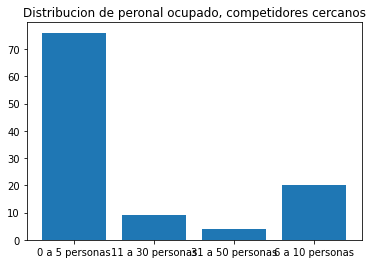

In [69]:
##Analisis por Spot
comp=pd.DataFrame([],columns=['N','D','S'])
for j in [0.5,1,3]:
  competencia_tot=[]
  i_cli=[]
  curr=pd.DataFrame([],columns=['N','D','S'])
  for i in range(0,len(cliente)):
      cercanos=competencia_cercana(i,j)
      competencia_tot=competencia_tot+cercanos
      i_cli=i_cli+(np.ones([len(cercanos)])*i).tolist()
  curr['N']=competencia_tot
  curr['D']=j
  curr['S']=i_cli

  comp=comp.append(curr)


##Analisis por Spot
plot_locales(cliente,Tabla.iloc[np.unique(comp.N.values)],'Dirección',13)
T=Tabla.iloc[np.unique(comp.N.values)]
S=pd.DataFrame(T).groupby('per_ocu').count().id
S.values
height = S.values
bars = S.index
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title('Distribucion de peronal ocupado, competidores cercanos')
plt.show()

In [30]:
#Competencia cercana a los spots
Tabla.iloc[np.unique(comp.N.values)]

,id,nom_estab,per_ocu,latitud,longitud,Manzana,Numero,Y_alta
97288,9103897,3 SESENTA PIZZERIA DE BARRIO,6 a 10 personas,19.373831,-99.156132,MIGUEL LAURENT/TAJIN/PETEN/PILARES,1154.0,2019
97309,7232067,480 LA PIZZA,11 a 30 personas,19.353760,-99.158705,XICOTENCATL/GOMEZ FARIAS/MORELOS/MALINTZIN,256.0,2019
101839,8392137,ARDENTE PIZZERIA NAPOLETANA,11 a 30 personas,19.412976,-99.171223,LAREDO/NUEVO LEON/AMSTERDAM/PARRAS,13.0,2019
102939,9171963,BENEDETTIS PIZZA,6 a 10 personas,19.389570,-99.191888,10/TOLTECAS/FERROCARRIL DE CUERNAVACA/16,132.0,2019
107754,9093495,CENTRAL DE PIZZAS,11 a 30 personas,19.402139,-99.150680,DOCTOR JOSE MARIA VERTIZ/PRESIDENTE MIGUEL ALE...,523.0,2019
...,...,...,...,...,...,...,...,...
145668,7743121,SUPER PIZZAS,0 a 5 personas,19.448476,-99.162285,CEDRO/1 NORTE (JOSE ANTONIO ALZATE)/MIRTO/FRESNO,159.0,2019
152135,7399721,TERE PIZZAS,0 a 5 personas,19.445833,-99.180596,MARINA NACIONAL/LAGO ISEO/LAGO SILVERIO/LAGO B...,173.0,2019
154678,7982957,VEGGINOS PIZZA,0 a 5 personas,19.407753,-99.189252,GOBERNADOR AGUSTIN VICENTE EGUIA/GOBERNADOR RA...,72.0,2019
154734,9114236,VENTA DE ALIMENTOS FRIKI PIZZA,6 a 10 personas,19.431034,-99.140846,REPUBLICA DE URUGUAY/NINGUNO/BOLIVAR/REPÚBLICA...,17.0,2019


In [71]:
#cercania locales competencia 
comp.groupby(['S','D']).count()

N
S   D      
0.0 0.5   3
    1.0  11
    3.0  49
1.0 1.0   4
    3.0  45
2.0 1.0   3
    3.0  33
3.0 1.0   5
    3.0  33
4.0 1.0   5
    3.0  20



*   Con la tabla anterior concluimos que el el spot 4 es el que tiene menos
competencia a 3km a la redonda , sin embargo tiene 5 pizzerias a menos de 1 km. 
*   el spot cero es el que tiene mas competencia 
*   el spot 2 es el que menos competencia tiene a menos de 1 km


**Conclusion : recomendar el spot 4 al cliente **

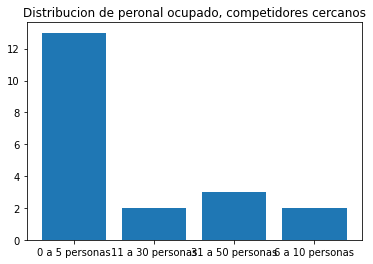

In [72]:
##Analisis por Spot
Spot=4
radio=0.5
competencia=competencia_cercana(Spot,3)
plot_locales(cliente.iloc[[Spot]],Tabla.iloc[competencia],'Dirección',13)
T=Tabla.iloc[competencia]
S=pd.DataFrame(T).groupby('per_ocu').count().id
S.values
height = S.values
bars = S.index
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.title('Distribucion de peronal ocupado, competidores cercanos')
plt.show()